In [2]:
import pandas as pd
import networkx as nx
import re
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2 as FA2 # pip install fa2
from heapq import nlargest
from operator import itemgetter
import operator
import numpy as np
import community # pip install python-louvain
import random
import io
import unicodedata
import unidecode # pip install Unidecode
from wordcloud import WordCloud # pip install wordcloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import math
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fpegios\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fpegios\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 2 - What do republican and democratic members tweet about?

**Exercise 4 - TF-IDF of the republican and democratic tweets**

We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud. The procedure you should use is exactly the same you used in exercise 2 of week 7. The main steps are summarized below:

* Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.
* Exclude all twitter handles.
* Exclude punctuation.
* Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
* Exclude numbers (since they're difficult to interpret in the word cloud).
* Set everything to lower case.
* Compute the TF-IDF for each document.
* Now, create word-cloud for each party. Are these topics less "boring" than the wikipedia topics? Why? Comment on the results.            

In [18]:
df2 = pd.read_csv('./115_tw_2019.csv', encoding = "utf-8") # read file with twitter and party associated
RepublicanDocument = "" # create document for republican tweets which is a big string
DemocraticDocument = ""# create document for democratic tweets which is a big string

count_demo = 0 #counter of democratic politician
count_rep = 0 #counter of republican politician

for value in df2.values:
    name = value[0]
    party = value[1]

    with io.open("./tweets_2019_full/" + name, "r", encoding="utf-8") as f:
        tweets = f.read() 
        
    tweets = unicodedata.normalize('NFKD', tweets).encode('ascii','ignore') # unicode to string
    tweets = tweets.decode('utf-8')
    
    tweets = re.sub(r"http\S+", "", tweets) # clear all links
    tweets = re.sub(r"@\S+", "", tweets) # clear all user name
    tweets = re.sub(r'\W+', ' ', tweets) # clear all ponctuation

    if party == "Democratic":
        count_demo += 1 # count number of democratic
        DemocraticDocument += tweets # append tweets from the current reached file
    else:
        count_rep +=1
        RepublicanDocument += tweets

print('done')

done


In [19]:
# compute Term frequency for each document
from nltk import word_tokenize

# function which take a nltk.Text in parameter and return list of tuple(tokens, occurrence)
def countWord(text):
    fdist = nltk.FreqDist([w.lower() for w in text])
    words = []

    for key in fdist.keys():
        if key not in nltk.corpus.stopwords.words() and key.lower().isalpha(): # transform in lower case and drop numbers
            words.append((fdist[key], key))
    words = sorted(words, reverse=True)
    return words

#Democratic
DemocraticDocumentString = ''

# for value in DemocraticDocument:
#     DemocraticDocumentString = DemocraticDocumentString + str(' ' + value)
    
tokens = nltk.word_tokenize(DemocraticDocument) # tokenize the document 
DemocraticDocument = nltk.Text(tokens) # create Text with the list of token
demo_tockens = countWord(DemocraticDocument) # count occurs
print('done demo')

#Republican
RepublicanDocumentString = ''

# for value in RepublicanDocument:
#     RepublicanDocumentString = RepublicanDocumentString + str(' ' + value)

tokens = nltk.word_tokenize(RepublicanDocument)
RepublicanDocument = nltk.Text(tokens)
repu_tockens = countWord(RepublicanDocument)
print('done repu')

done demo
done repu


In [21]:
# compute Inverse document frequency for each document
demo_idf = {}
repu_idf = {}

# republican
for count, word in repu_tockens:
    repu_idf[word] = math.log10(float(count_rep) / float(count))

# democratic
for count, word in demo_tockens:
    demo_idf[word] = math.log10(float(count_rep) / float(count))

In [22]:
# cast list of tuple to dict 
repu_tockens_dict = {}
for i in range(len(repu_tockens)):
    repu_tockens_dict[repu_tockens[i][1]]= repu_tockens[i][0]

demo_tockens_dict = {}
for i in range(len(demo_tockens)):
    demo_tockens_dict[demo_tockens[i][1]]= demo_tockens[i][0]

In [27]:
# compute Term frequency–Inverse document frequency
demo_tfidf = {}
repu_tfidf = {}

for key, value in repu_idf.items():
    repu_tfidf[key] = repu_tockens_dict[key] * repu_idf[key]

for key, value in demo_idf.items():
    demo_tfidf[key] = demo_tockens_dict[key] * demo_idf[key]
    
print('done')

done


In [24]:
# join words into long string

# democrats
demo_words_sorted = sorted(demo_tfidf.items(), key=lambda x: x[1], reverse=True) # make complete sorted list of words
demo_words_string = ""

for pair in demo_words_sorted:
    for i in range(int(math.ceil(pair[1]))):
        demo_words_string += pair[0] + " "

# republicans
repu_words_sorted = sorted(repu_tfidf.items(), key=lambda x: x[1], reverse=True) # make complete sorted list of words
repu_words_string = ""

for pair in repu_words_sorted:
    for i in range(int(math.ceil(pair[1]))):
        repu_words_string += pair[0] + " "

print('done')

done


In [32]:
# Generate a word cloud images

#source: https://stackoverflow.com/a/43043723
def demo_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 150.0 / 255.0) # hue = 150 for blue
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random.randint(40, 180)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def repu_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 0.0 / 255.0) # hue = 0 for red
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random.randint(40, 180)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

# collocations=False to avoid words like "maryland maryland" in the wordcloud
demo_wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(demo_words_string)
repu_wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(repu_words_string)

demo_wordcloud.recolor(color_func=demo_color_func)
repu_wordcloud.recolor(color_func=repu_color_func)

print('done')

done


Now, create word-cloud for each party.

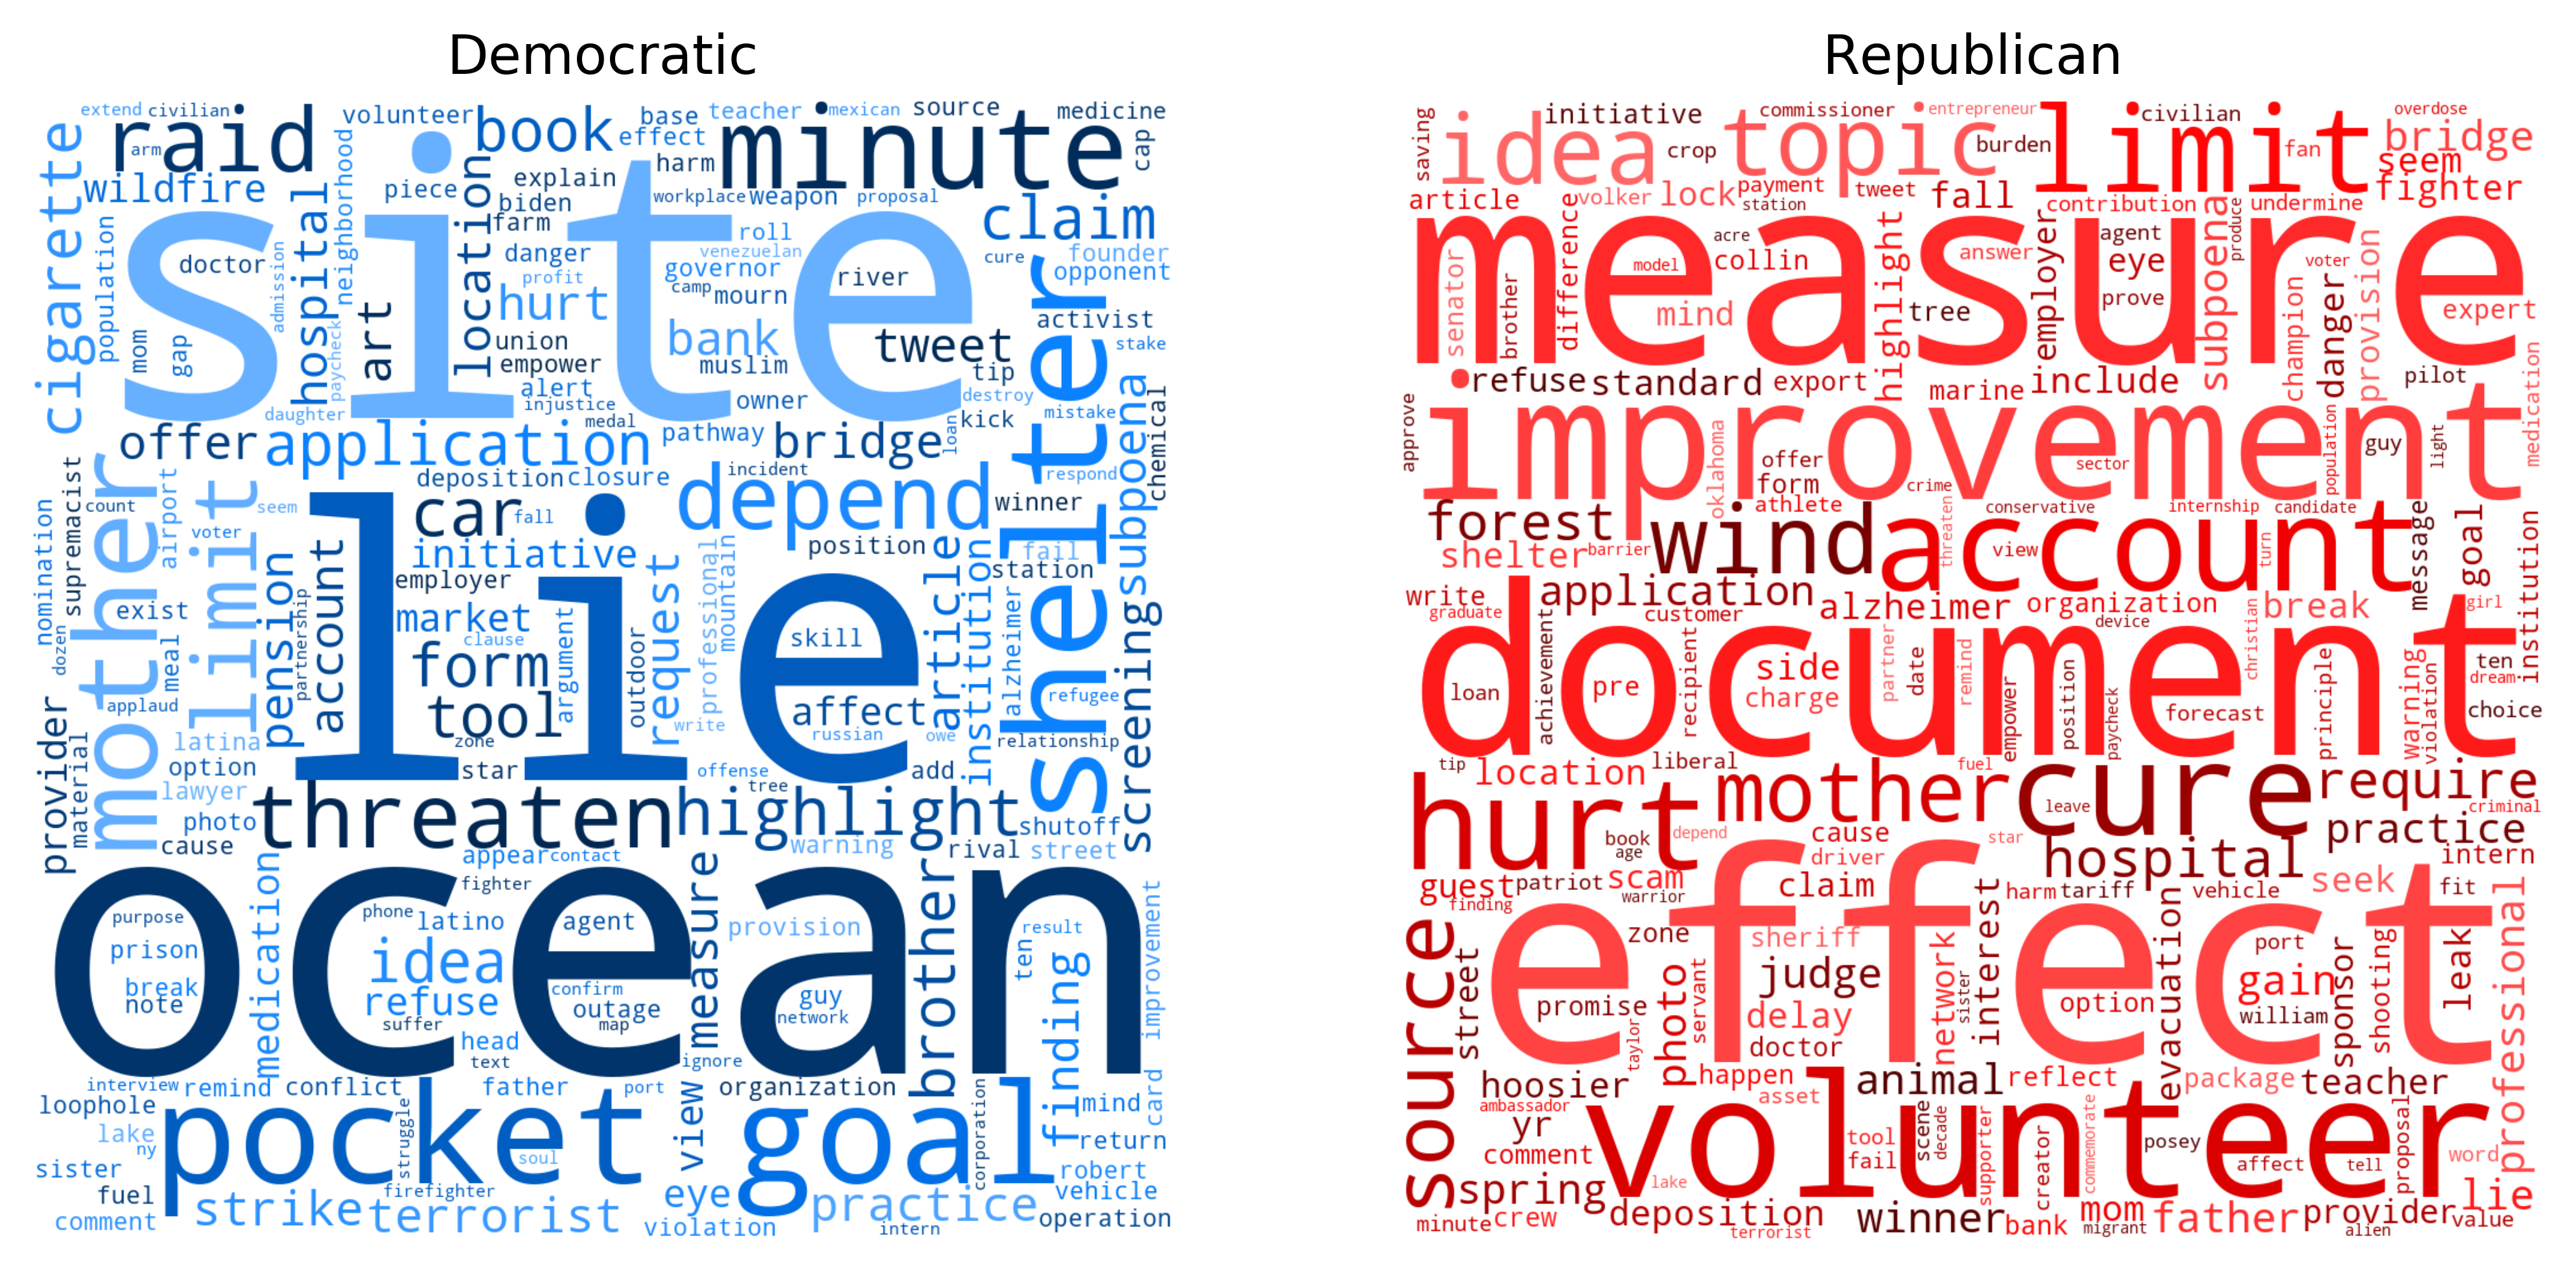

In [33]:
# Display the generated images

# enable plotting in two columns
fig, axs = plt.subplots(ncols=2, figsize=(10, 10), dpi=500)

axs[0].imshow(demo_wordcloud, interpolation='bilinear')
axs[0].set_title("Democratic")
axs[0].axis("off")

axs[1].imshow(repu_wordcloud, interpolation='bilinear')
axs[1].set_title("Republican")
axs[1].axis("off")

plt.show()